In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 

# datetime utilities
from datetime import timedelta, datetime

from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings("ignore")

import acquire as get
import prepare as prep

# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

Do your work for this exercise in a notebook named explore. Use the techniques in the lesson to explore the store item demand dataset and the opsd dataset.

For the store item demand data, you will need to choose a method of aggregating such that each observation is a unique date. For both datasets you should choose a method of splitting your data and only explore the training split.

In [2]:
df = prep.prepare_store_data()

Using cached CSV


,sale_id,store_id,item_id,item_brand,item_name,item_price,sale_amount,store_address,store_city,store_state,store_zipcode,item_upc12,item_upc14,month,day_of_week,sales_total
sale_date,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,1,1,1,Riceland,Riceland American Jazmine Rice,0.84,13.0,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,35200264013,35200264013,January,Tuesday,10.92
2013-01-01 00:00:00+00:00,211817,7,12,Mueller,Mueller Sport Care Basic Support Level Medium Elastic Knee Support,8.40,26.0,12018 Perrin Beitel Rd,San Antonio,TX,78217,74676640211,74676640211,January,Tuesday,218.40
2013-01-01 00:00:00+00:00,832657,7,46,Mama Marys,Pizza Sauce,4.65,27.0,12018 Perrin Beitel Rd,San Antonio,TX,78217,35457770664,35457770664,January,Tuesday,125.55
2013-01-01 00:00:00+00:00,213643,8,12,Mueller,Mueller Sport Care Basic Support Level Medium Elastic Knee Support,8.40,54.0,15000 San Pedro Ave,San Antonio,TX,78232,74676640211,74676640211,January,Tuesday,453.60
2013-01-01 00:00:00+00:00,215469,9,12,Mueller,Mueller Sport Care Basic Support Level Medium Elastic Knee Support,8.40,35.0,735 SW Military Dr,San Antonio,TX,78221,74676640211,74676640211,January,Tuesday,294.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 00:00:00+00:00,619014,9,34,Halls,Halls Menthol Cough Suppresant/oral Anesthetic Drops Honey-lemon - 30 Ct,4.17,21.0,735 SW Military Dr,San Antonio,TX,78221,312546628694,312546628694,December,Sunday,87.57
2017-12-31 00:00:00+00:00,620840,10,34,Halls,Halls Menthol Cough Suppresant/oral Anesthetic Drops Honey-lemon - 30 Ct,4.17,32.0,8503 NW Military Hwy,San Antonio,TX,78231,312546628694,312546628694,December,Sunday,133.44
2017-12-31 00:00:00+00:00,622666,1,35,Natures Way,Natures Way Forskohlii - 60 Ct,5.19,55.0,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,33674100066,33674100066,December,Sunday,285.45


In [3]:
opsd = prep.prepare_opsd_data()

In [4]:
opsd

,Consumption,Wind,Solar,Wind+Solar,month,year
Date,,,,,,
2006-01-01,1069.18400,0,0,0,1,2006
2006-01-02,1380.52100,0,0,0,1,2006
2006-01-03,1442.53300,0,0,0,1,2006
2006-01-04,1457.21700,0,0,0,1,2006
2006-01-05,1477.13100,0,0,0,1,2006
...,...,...,...,...,...,...
2017-12-27,1263.94091,394.507,16.53,411.037,12,2017
2017-12-28,1299.86398,506.424,14.162,520.586,12,2017
2017-12-29,1295.08753,584.277,29.854,614.131,12,2017


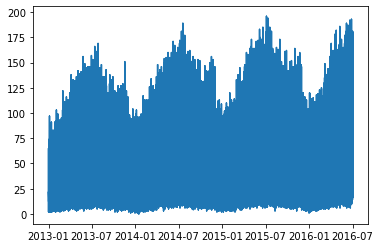

In [5]:
# I'll start by using a percentage-based split of the store df. 

train_size = .70
n = df.shape[0]
test_start_index = round(train_size * n)

train = df[:test_start_index] # everything up to (not including) the test_start_index
test = df[test_start_index:] # everything from the test_start_index to the end

plt.plot(train.index, train.sale_amount)

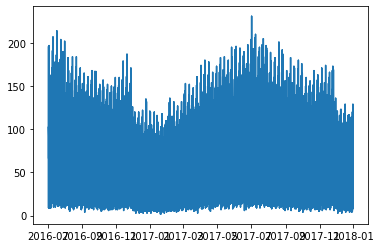

In [6]:
plt.plot(test.index, test.sale_amount)

In [11]:
opsd.index

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=4383, freq=None)

In [12]:
opsd.columns

Index(['Consumption', 'Wind', 'Solar', 'Wind+Solar', 'month', 'year'], dtype='object')

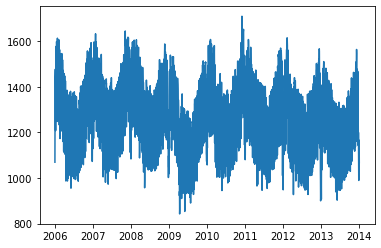

In [7]:
# I will implement a 'Human-Based' approach for OPSD
train_op = opsd[:'2013'] # includes 2013
test_op = opsd['2014':] # 2014 'til the end

plt.plot(train_op.index, train_op.Consumption)


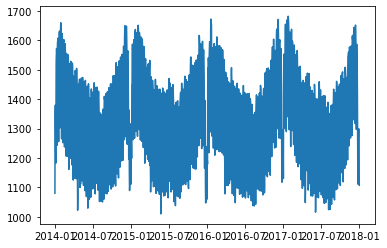

In [8]:
plt.plot(test_op.index, test_op.Consumption)

In [9]:
# Groovy, it worked just fine. Now let's explore the Train set for each. 
# i'll establish what my target (dependent variable) is for each. 
# Consumption for opsd and sales_total for the sales df are viable targets. 

y1 = train.sales_total
y1.head()

sale_date
2013-01-01 00:00:00+00:00     10.92
2013-01-01 00:00:00+00:00    218.40
2013-01-01 00:00:00+00:00    125.55
2013-01-01 00:00:00+00:00    453.60
2013-01-01 00:00:00+00:00    294.00
Name: sales_total, dtype: float64

<AxesSubplot:ylabel='Frequency'>

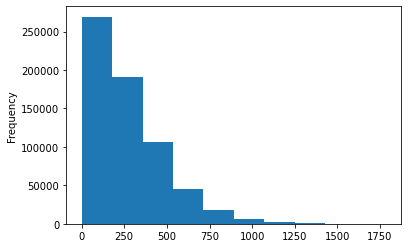

In [11]:
y1.plot.hist()

[Text(0.5, 1.0, 'Average Sales Per Month'),
 Text(0.5, 0, 'MOnth'),
 Text(0, 0.5, 'Sales Totals')]

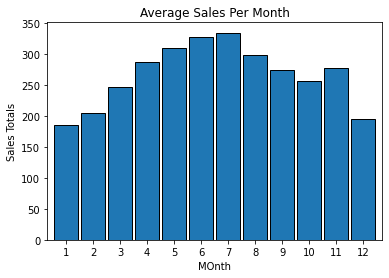

In [13]:
ax = y1.groupby(y1.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Sales Per Month', xlabel='MOnth', ylabel='Sales Totals')

[Text(0.5, 1.0, 'Average Sales Per Day'),
 Text(0.5, 0, 'Day of the Week'),
 Text(0, 0.5, 'Sales Totals')]

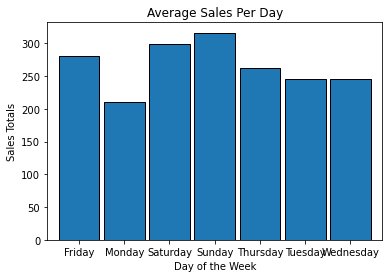

In [15]:
ax = y1.groupby(y1.index.day_name()).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Sales Per Day', xlabel='Day of the Week', ylabel='Sales Totals')

<AxesSubplot:title={'center':'6 hour average'}, xlabel='sale_date'>

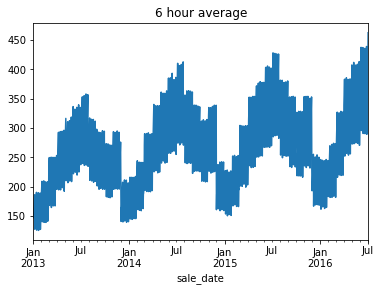

In [25]:
y1.resample('D').mean().plot(title='Daily Average')

In [23]:
#(
#    y1.reset_index()
#    .assign(weekday=lambda df: df.datetime.dt.day_name())
#    .pipe((sns.boxplot, 'data'), y='sales_totals', x='weekday')
#)

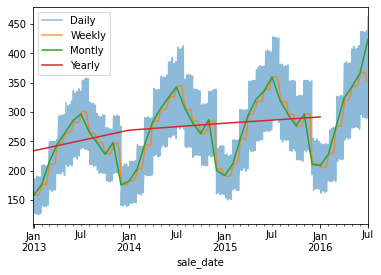

In [45]:
y1.resample('D').mean().plot(alpha=.5, label='Daily')
y1.resample('W').mean().plot(alpha=.8, label='Weekly')
y1.resample('M').mean().plot(label='Montly')
y1.resample('Y').mean().plot(label='Yearly')
plt.legend()

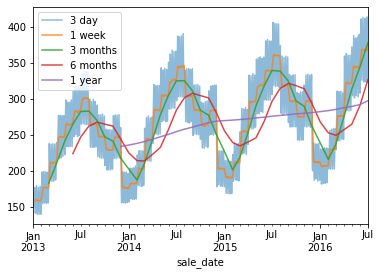

In [52]:
# the rolling method 
y1.resample('D').mean().rolling(3).mean().plot(alpha=.5, label='3 day')
y1.resample('D').mean().rolling(7).mean().plot(alpha=.8, label='1 week')
y1.resample('M').mean().rolling(3).mean().plot(alpha=.85, label='3 months')
y1.resample('M').mean().rolling(6).mean().plot(alpha=.85, label='6 months')
y1.resample('M').mean().rolling(12).mean().plot(alpha=.85, label='1 year')
plt.legend()

<AxesSubplot:title={'center':'Seasonal Plot'}, xlabel='sale_date'>

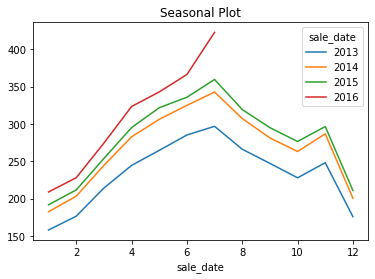

In [53]:
# Seasonal Plot 
# .unstack turns an index level into columns
y1.groupby([y1.index.year, y1.index.month]).mean().unstack(0).plot(title='Seasonal Plot')



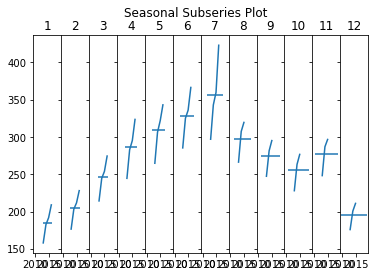

In [55]:
table = y1.groupby([y1.index.year, y1.index.month]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim())
    ax.set(xlabel='')

fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)

Text(0.5, 1.0, 'Lag plot with lag=1')

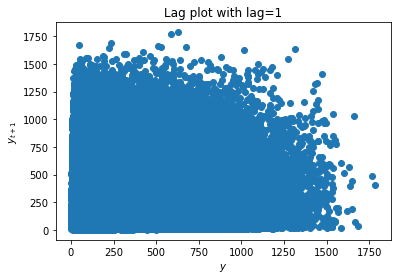

In [57]:
plt.scatter(y1, y1.shift(-1))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

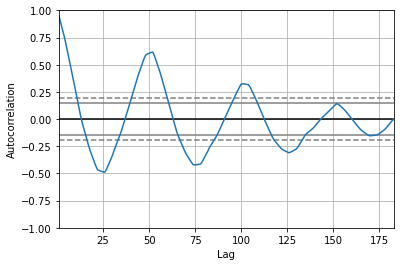

In [60]:
pd.plotting.autocorrelation_plot(train.sales_total.resample('W').mean())


In [63]:
y = train.sales_total.resample('W').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()

,y,trend,seasonal,resid
sale_date,,,,
2013-01-06 00:00:00+00:00,163.589167,NaN,-77.817427,NaN
2013-01-13 00:00:00+00:00,159.981203,NaN,-76.420498,NaN
2013-01-20 00:00:00+00:00,157.946720,NaN,-77.661680,NaN
2013-01-27 00:00:00+00:00,158.545383,NaN,-77.653889,NaN
2013-02-03 00:00:00+00:00,167.585014,NaN,-73.077372,NaN


<AxesSubplot:xlabel='sale_date'>

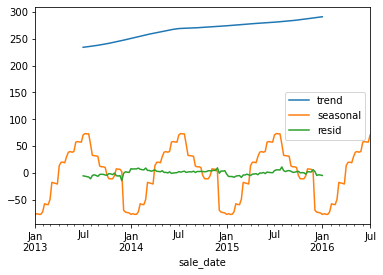

In [64]:
decomposition.iloc[:, 1:].plot()

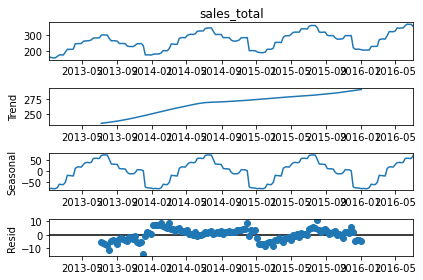

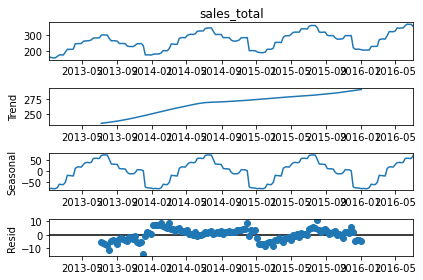

In [65]:
result.plot()

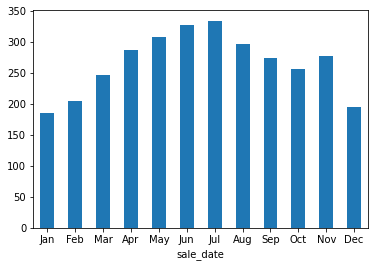

In [70]:
ax = y1.groupby(y1.index.strftime('%m-%b')).mean().plot.bar()
ax.set_xticklabels([t.get_text()[3:] for t in ax.get_xticklabels()], rotation=0)
None

In [10]:
# I wonder if there would be some value behind consolidating by date with the total sales amount of all items, irrespective of individual sales amounts or products. 
y2 = train_op.Consumption
y2.head()

Date
2006-01-01    1069.184
2006-01-02    1380.521
2006-01-03    1442.533
2006-01-04    1457.217
2006-01-05    1477.131
Name: Consumption, dtype: float64

<AxesSubplot:ylabel='Frequency'>

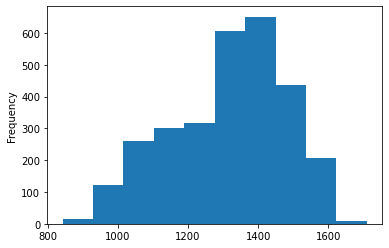

In [12]:
y2.plot.hist()

[Text(0.5, 1.0, 'Average Monthly Energy Consumption'),
 Text(0.5, 0, 'MOnth'),
 Text(0, 0.5, 'Consumption')]

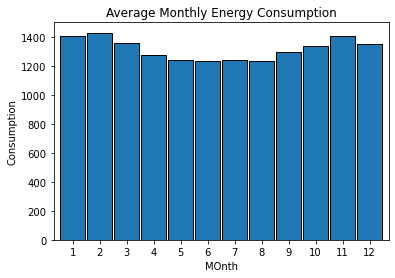

In [14]:
ax = y2.groupby(y2.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Monthly Energy Consumption', xlabel='MOnth', ylabel='Consumption')

[Text(0.5, 1.0, 'Daily Energy Consumption'),
 Text(0.5, 0, 'Day of the Week'),
 Text(0, 0.5, 'Energy Usage')]

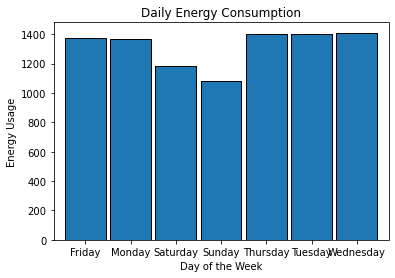

In [17]:
ax = y2.groupby(y2.index.day_name()).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Daily Energy Consumption', xlabel='Day of the Week', ylabel='Energy Usage')

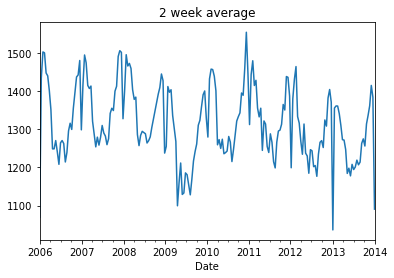

In [31]:
y2.resample('2W').mean().plot(title='2 week average')

<AxesSubplot:title={'center':'Seasonal Plot'}, xlabel='Date'>

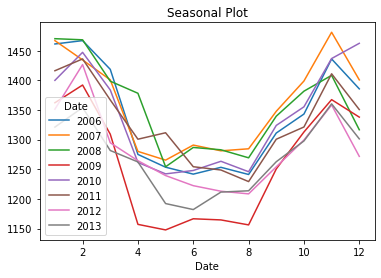

In [54]:
# .unstack turns an index level into columns
y2.groupby([y2.index.year, y2.index.month]).mean().unstack(0).plot(title='Seasonal Plot')

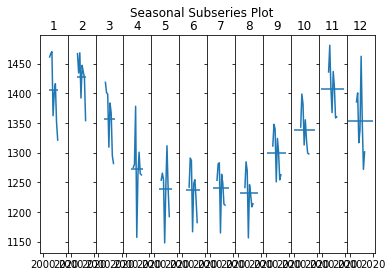

In [56]:
table = y2.groupby([y2.index.year, y2.index.month]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim())
    ax.set(xlabel='')

fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)

Text(0.5, 1.0, 'Lag plot with lag=1')

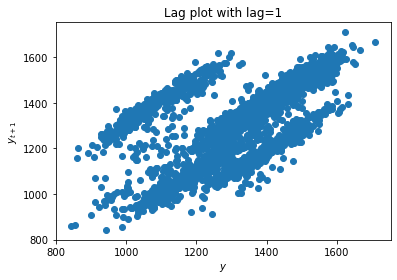

In [58]:
plt.scatter(y2, y2.shift(-1))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

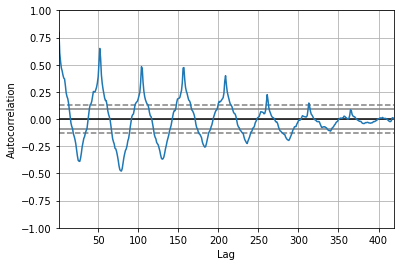

In [62]:
pd.plotting.autocorrelation_plot(train_op.Consumption.resample('W').mean())

In [67]:
y = train_op.Consumption.resample('W').mean()

result2 = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()


,y,trend,seasonal,resid
sale_date,,,,
2013-01-06 00:00:00+00:00,163.589167,NaN,-77.817427,NaN
2013-01-13 00:00:00+00:00,159.981203,NaN,-76.420498,NaN
2013-01-20 00:00:00+00:00,157.946720,NaN,-77.661680,NaN
2013-01-27 00:00:00+00:00,158.545383,NaN,-77.653889,NaN
2013-02-03 00:00:00+00:00,167.585014,NaN,-73.077372,NaN


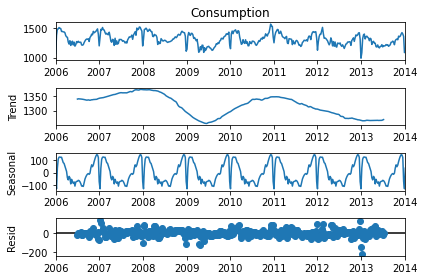

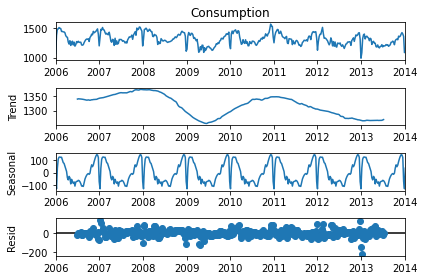

In [68]:
result2.plot()

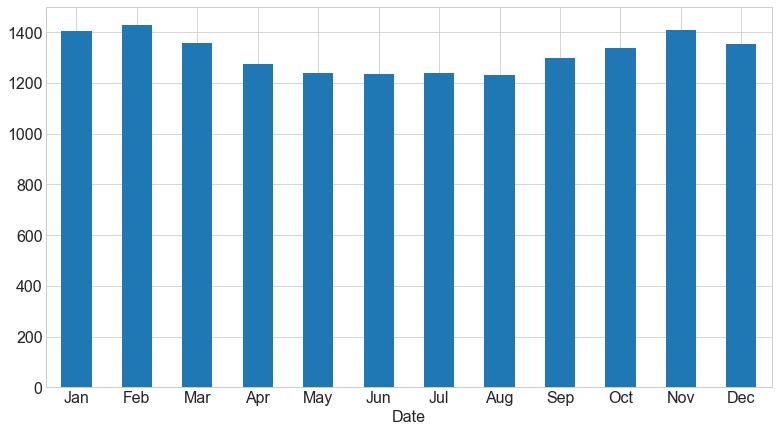

In [72]:
ax = y2.groupby(y2.index.strftime('%m-%b')).mean().plot.bar()
ax.set_xticklabels([t.get_text()[3:] for t in ax.get_xticklabels()], rotation=0)
None

In [ ]:
train_op2 = train_op.resample('D').mean()
# create a categorical feature
train_op2['temp_bin'] = pd.qcut(train_op2.temp, 4, labels=['cold', 'cool', 'warm', 'hot'])
train_op2.groupby('temp_bin').mean()

In [34]:
ooh = y2.resample('2W').mean()

In [42]:
import plotly.express as px
# Construct the graph and style it. Further customize your graph by editing this code.
# See Plotly Documentation for help: https://plotly.com/python/plotly-express/
fig = px.scatter(opsd, y='Consumption', color='month')
fig.update_layout(
    title='Annual Energy Consumption - Scatter Plot', 
    xaxis = dict(
        title='Year after Year with a Monthly Hue', 
        rangeslider = dict(
            visible=False, 
            thickness=0.05
        )
    ), 
    yaxis = dict(

    ), 
    paper_bgcolor='#FFFFFF', 
    plot_bgcolor='#94e3fe', 
    showlegend=True
)
fig.show(renderer="iframe")